> Created on Sat Jun  3 21:56:11 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.5-D 马尔可夫随机场

## 3.5.1 无向图模型

### 3.5.1.1 参数化马尔可夫网（Markov Network）

<img src="../imgs/3_5_d/3_5_d_03.png" height='auto' width=200 title="caDesign"> 

如果假设有4个表征土地利用（landuse，LU）类型邻接的栅格单元（如图）$A,B,C,D$作为随机变量，每个变量可能分配的 LU 类型只有两类，住宅和绿地，用数值0和1表示分配的状态。那么，$\{A,B\}$、$\{B,C)\}$、$\{C,D\}$和$\{D,A\}$之间分配的 LU 类型可能的状态为住宅对住宅（0对0）、住宅对绿地（0对1）、绿地对住宅（1对0）和绿地对绿地（1对1）等4种结果，并希望满足$(A \perp C \mid\{B, D\})$和$(B \perp D \mid\{A, C\})$而不包括其它独立性条件的分布进行建模。可以发现该类问题两两随机变量之间存在的边并没有方向，而是对称的，因此构建无向图模型（马尔可夫网（Markov Network，MN）），书写代码绘制节点和边如下。

In [219]:
%load_ext autoreload 
%autoreload 2 
import warnings
warnings.filterwarnings('ignore')

import usda.pgm as usda_pgm
import usda.data_visual as usda_vis

from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


绘制无向图网络。

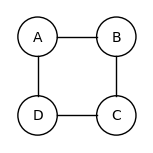

In [61]:
import daft

# Instantiate the PGM.
pgm=daft.PGM(node_unit=1, grid_unit=2, directed=False,dpi=100)

pgm.add_node('A','A',0,1)
pgm.add_node('B','B',1,1)
pgm.add_node('C','C',1,0)
pgm.add_node('D','D',0,0)

pgm.add_edge('A','B')
pgm.add_edge('B','C')
pgm.add_edge('C','D')
pgm.add_edge('D','A')

pgm.render();

以$\{A,B\}$之间的 LU 类型邻接关系为例，如果同为住宅的可能性（30）大于同为绿地的可能性（10），并大于二者为不同类型的可能性。且为不同类型时，$A$为住宅对$B$为绿地的可能性（5）大于$A$为绿地而$B$为住宅的可能性（1）。那么，可以配置$\{A,B\}$邻接关系的概率如下图（使用[pgmpy库](https://github.com/pgmpy/pgmpy)实现，并定义`draw_factor_graph()`方法绘制网络）。将$\{A,B\}$状态关系概率的描述定义为一个具有通用目标的函数（ general-purpose function），这个函数也被称为一个因子（factor）（或称为势函数（potential function）），有如下定义。

定义： 假设$D$表示随机变量的集合，因子$\phi$定义为从$Val(D)$映射到实数域$R$的一个函数。假如因子的所有表值均非负，那么这个因子是非负的（nonnegative），变量集$D$称为因子的**辖域（scope ）**，记为$Scopt[\phi]$。

上述$\{A,B\}$状态概率关系中的因子可以写为$\phi(A, B): \operatorname{Val}(A, B) \mapsto \boldsymbol{R}^{+} $，因子的值`(30,5,1,10)`并没有归一化，且不一定在`[0,1]`之内。

+------+------+------------+
| A    | B    |   phi(A,B) |
+======+======+============+
| A(0) | B(0) |    30.0000 |
+------+------+------------+
| A(0) | B(1) |     5.0000 |
+------+------+------------+
| A(1) | B(0) |     1.0000 |
+------+------+------------+
| A(1) | B(1) |    10.0000 |
+------+------+------------+
True


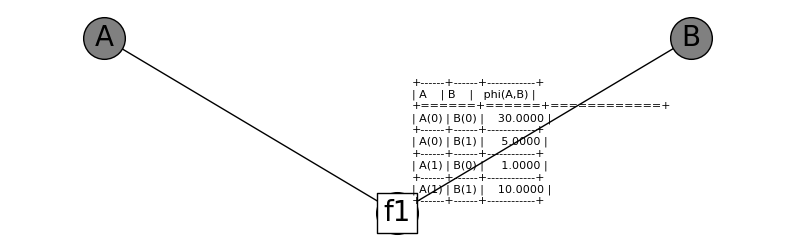

In [62]:
G=FactorGraph()
G.add_nodes_from(['A','B'])
phi=DiscreteFactor(['A','B'],[2,2],[30,5,1,10])
print(phi)
G.add_factors(phi)
G.add_nodes_from([phi])
G.add_edges_from([('A', phi), ('B', phi)])
print(G.check_model())
usda_pgm.draw_factor_graph(G)  

配置随机变量间所有 LU 类型邻接关系的因子，如下代码和打印的因子图，

定义：**因子图** $\mathcal{F}$是包含变量节点（椭圆或圆表示）与因子节点（方形表示）的一个无向图。该图只包含变量节点和因子节点之间的边，并由一系列因子参数化，其中每个因子节点$V_\phi$正好与因子$\phi$相关联，其辖域是图中与$V_\phi$相邻节点的变量集。

因为示例中每个变量（栅格单元）(总共4个变量)有两个状态（住宅0和绿地1），因此连接两个变量的每个因子参数个数为4个，那么图中参数的总数为$4\left(\begin{array}{l}n \\2\end{array}\right)=4 \times 4=16$。

In [220]:
G=FactorGraph()
G.add_nodes_from(['A','B','C','D'])
phi1=DiscreteFactor(['A','B'],[2,2],[30,5,1,10])
phi2=DiscreteFactor(['B','C'],[2,2],[100,1,1,100])
phi3=DiscreteFactor(['C','D'],[2,2],[1,100,100,1])
phi4=DiscreteFactor(['D','A'],[2,2],[100,1,1,100])

G.add_factors(phi1,phi2,phi3,phi4)
G.add_edges_from([('A', phi1), ('A', phi4),
                  ('B', phi1), ('B', phi2),
                  ('C', phi2), ('C', phi3),
                  ('D', phi3), ('D', phi4)])
print(G.check_model())

True


绘制因子图。

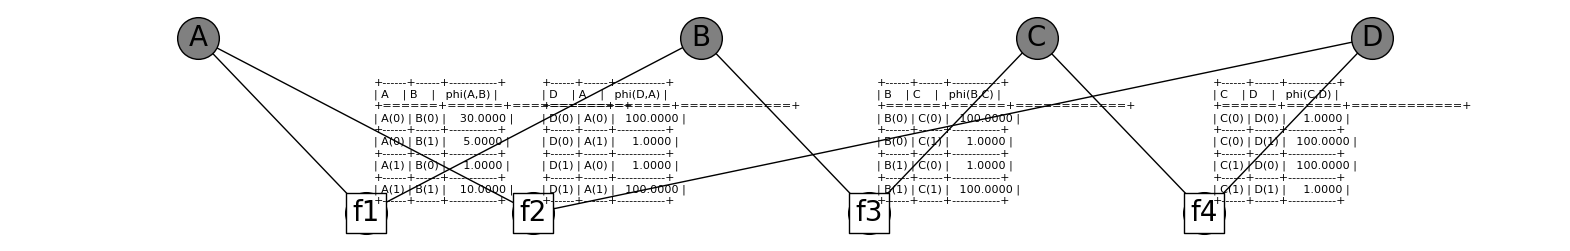

In [64]:
usda_pgm.draw_factor_graph(G,figsize=(20,3))  

通过定义的变量间局部交互影响（局部模型（local model））定义全局模型（global model），以局部模型相乘的方式进行组合。例如，示例中结果`phi(A,B,C,D)`列。

In [221]:
phi=phi1*phi2*phi3*phi4
print(phi)

+------+------+------+------+----------------+
| B    | C    | A    | D    |   phi(B,C,A,D) |
+======+======+======+======+================+
| B(0) | C(0) | A(0) | D(0) |    300000.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(0) | D(1) |    300000.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(0) |       100.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(1) |   1000000.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(0) |    300000.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(1) |        30.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(0) |       100.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(1) |       100.0000 |
+------+------+------+------+----------------+
| B(1) | C(0) | A(0) | D(0) |       500.0000 |
+------+------+------+------+----------------+
| B(1) | C(0)

因为相乘的结果并不能保证是一个归一化的联合概率分布（joint probability distribution，JPD），因此定义，$P(a, b, c, d)=\frac{1}{Z} \phi_1(a, b) \cdot \phi_2(b, c) \cdot \phi_3(c, d) \cdot \phi_4(d, a)$，式中，$Z=\sum_{a, b, c, d} \phi_1(a, b) \cdot \phi_2(b, c) \cdot \phi_3(c, d) \cdot \phi_4(d, a)$。$Z$是一个归一化常数，通常称为配分函数（partition function），“配分（partition）”一词源于马尔可夫网的早期历史，而马尔可夫网则源自统计物理学中的马尔可夫随机场（Markov random field，MRF）。使用“函数”一词则是因为$Z$的值是参数的一个函数。归一化结果如下计算结果`phi(A,B,C,D)`列。

In [222]:
phi.normalize()
print(phi)

+------+------+------+------+----------------+
| B    | C    | A    | D    |   phi(B,C,A,D) |
+======+======+======+======+================+
| B(0) | C(0) | A(0) | D(0) |         0.0417 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(0) | D(1) |         0.0417 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(0) |         0.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(1) |         0.1389 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(0) |         0.0417 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(1) |         0.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(0) |         0.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(1) |         0.0000 |
+------+------+------+------+----------------+
| B(1) | C(0) | A(0) | D(0) |         0.0001 |
+------+------+------+------+----------------+
| B(1) | C(0)

获得 JPD 后，可以用其回答查询，例如栅格单元$B$的 LU 类型为住宅或者为绿地的概率为0.263和0.736。计算的方法给出了两种，一种是用边缘化`marginalize`方法，对归一化的 JPD 操作；另一种是用`VariableElimination`结合`query`方法，将为`pgmpy.models.FactorGraph.FactorGraph`对象的`G`，转化为为`pgmpy.models.MarkovNetwork.MarkovNetwork`对象的`mm`后，对`mm`操作。

In [67]:
B_marginalized=phi.marginalize(['A','C','D'],inplace=False)
print(B_marginalized)

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2639 |
+------+----------+
| B(1) |   0.7361 |
+------+----------+


`query`方法查询的结果并没有实现归一化，因此除以配分函数$Z$，计算结果同上。

In [228]:
from pgmpy.inference import VariableElimination,BeliefPropagation
mm=G.to_markov_model()
infer=VariableElimination(mm)
B_prob=infer.query(['B'])
print(B_prob)

Z=G.get_partition_function()
print(Z)
print(B_prob.values/Z)

+------+--------------+
| B    |       phi(B) |
+======+==============+
| B(0) | 1900330.0000 |
+------+--------------+
| B(1) | 5301510.0000 |
+------+--------------+
7201840.0
[0.26386729 0.73613271]


又例如给定证据$C$的状态为住宅时，$B$的概率。计算方法也给出了两种，一种是对 JPD 直接计算，用到了因子约简`reduce`和`marginalize`方法；另一种是用`query`方法。

In [69]:
phi_reduced_C0=phi.reduce([('C',0)],inplace=False)
print(phi_reduced_C0)
B_reduced_marginalized=phi_reduced_C0.marginalize(['A','D'],inplace=False)
print(B_reduced_marginalized)

+------+------+------+--------------+
| D    | B    | A    |   phi(D,B,A) |
+======+======+======+==============+
| D(0) | B(0) | A(0) |       0.0417 |
+------+------+------+--------------+
| D(0) | B(0) | A(1) |       0.0000 |
+------+------+------+--------------+
| D(0) | B(1) | A(0) |       0.0001 |
+------+------+------+--------------+
| D(0) | B(1) | A(1) |       0.0000 |
+------+------+------+--------------+
| D(1) | B(0) | A(0) |       0.0417 |
+------+------+------+--------------+
| D(1) | B(0) | A(1) |       0.1389 |
+------+------+------+--------------+
| D(1) | B(1) | A(0) |       0.0001 |
+------+------+------+--------------+
| D(1) | B(1) | A(1) |       0.0139 |
+------+------+------+--------------+
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2222 |
+------+----------+
| B(1) |   0.0140 |
+------+----------+


In [224]:
B_prob_C0=infer.query(['B'],evidence={'C':0})
print(B_prob_C0)
print(B_prob_C0.values/Z)

+------+--------------+
| B    |       phi(B) |
+======+==============+
| B(0) | 1600100.0000 |
+------+--------------+
| B(1) |  101010.0000 |
+------+--------------+
[0.22217933 0.01402558]


### 3.5.1.2 吉布斯分布（Gibbs Distributions）

用因子积的更一般概念来定义一个分布的无向参数化。

定义：假如分布$P_{\Phi}$定义如下：$P_{\Phi}\left(X_1, \cdots, X_n\right)=\frac{1}{Z} \tilde{P}_{\Phi}\left(X_1, \cdots, X_n\right)$，式中，$\tilde{P}_{\Phi}\left(X_1, \cdots, X_n\right)=\phi_1\left(D_1\right) \times \phi_2\left(D_2\right) \times \cdots \times \phi_m\left(D_m\right)$是非归一化的度量，且$Z=\sum_{X_1.  \cdots. X_n} \tilde{P}_{\Phi}\left(X_1, \cdots, X_n\right)$为称为配分函数的归一化常数，那么分布$P_{\Phi}$称为由因子集$ \Phi=\left\{\phi_1\left(D_1\right), \cdots, \phi_\kappa\left(D_\kappa\right)\right.\}$参数化的吉布斯分布（Gibbs Distributions）。

如果仅考虑$\{A,B\}$的局部因子$\phi_1(a,b)$可以得知$\phi_1(a^0,b^0)$为最大值，即变量$A$和$B$同为住宅的可能性最大。但是观察基于吉布斯分布（总体分布）上的$\{A,B\}$关系可以发现$\phi_1(a^0,b^1)$，即$A$为住宅而$B$为绿地状态关系的可能性最大。造成这种不一致的原因来自于其它因子对分布的影响，可以发现，$\phi_3(C,D)$中$C$和$D$ LU 类型不一致的可能性最大，而$\phi_3(B,C)$和$\phi_4(D,A)$则表明对应变量 LU 类型一致的可能性最大，因此可以推测$A$和$B$ LU 类型不一致的可能性趋大。由于其它因子的影响值为100，而$\{A,B\}$局部因子为30，以至于其它因子的影响淹没了局部因子状态关系的概率。

In [71]:
print(infer.query(['A','B']))
print(infer.query(['A','B']).values/Z)

+------+------+--------------+
| A    | B    |     phi(A,B) |
+======+======+==============+
| A(0) | B(0) |  900030.0000 |
+------+------+--------------+
| A(0) | B(1) | 5001500.0000 |
+------+------+--------------+
| A(1) | B(0) | 1000300.0000 |
+------+------+--------------+
| A(1) | B(1) |  300010.0000 |
+------+------+--------------+
[[0.12497223 0.6944753 ]
 [0.13889506 0.04165741]]


再将吉布斯分布的参数化与图的结构联系起来时，定义有，假设每个$\boldsymbol{D}_k(k=1, \cdots, K)$都是$\mathcal{H}$的完全子图（complete subgraph），则称具有$\Phi=\left\{\phi_1\left(D_1\right), \cdots, \phi_k\left(D_k\right)\right\}$的分布$ P_{\Phi}$在马尔可夫网$\mathcal{H}$上因子分解。

参数化马尔可夫网的因子通常称为**团位势（clique potentials）**。

> 团（Clique）是无向图中顶点的子集，满足每两个不同的顶点都是相邻的，其子图为完全图（complete graph）。可查看*图属性的基本度量*章节。

由于每个完全子图都是某些（最大）团的子集，因此可以通过只允许对最大团设定因子的方式来减少因子的数量。令$\boldsymbol{C}_1, \cdots, \boldsymbol{C}_k$为$\mathcal{H}$中的团，可以利用一系列因子$\phi_1\left(\boldsymbol{C}_1\right), \cdots, \phi_l\left(\boldsymbol{C}_l\right)$来参数化$P$。通过简单的将每个因子指定给覆盖其辖域的一个团，并将指定给每个团的所有因子相乘，以这种生成团位势方式，任何根据完全子图的因子分解都可以转化为这一形式。在上述马尔可夫网示例中，包含有4个团，为$\{A,B\}\{B,C\}\{C,D\}\{D,A\}$。

### 3.5.1.3 对数线性模型

定义因子（势函数）时，并没有将因子限制为特定的概率分布，因此可以定义任意因子，但仍然需要满足$\phi(D) \geq 0$，保证$P(X) \geq 0$。通常$\phi(D)$可以改写为，$\phi(\boldsymbol{D})=\exp (-\epsilon(\boldsymbol{D}))$，式中，$\epsilon(D)=-\ln \phi(D)$通常叫做**能量函数**。"能量"一词来自于统计物理，其中物理状态的概率（如一系列电子的构型（conﬁguration））反比于其能量。在这个对数化的表示中，有$P\left(X_1, \cdots, X_n\right) \propto \exp \left[-\sum_{i=1}^m \epsilon_i\left(\boldsymbol{D}_i\right)\right]$。这种对数表示可以保证概率分布式正的，且对数的参数可以沿着实数轴任意取值。

打印能量函数曲线，观察数值分布和变化趋势。

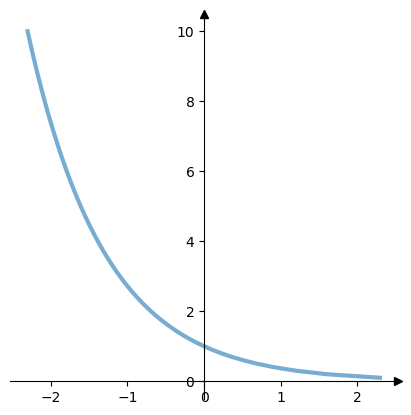

In [6]:
fig, ax=plt.subplots(1, 1,figsize=(5,5))
phi = np.linspace(0, 10, 100)
ax.plot(-np.log(phi),phi, lw=3, alpha=0.6)

usda_vis.plot_style_axis_A(ax)
plt.show()

计算示例团位势参数的对数表示，可以看到团位势中的表值1在能量函数中转化成立0，即两个变量的取值一致时，该能量函数的值为1；当两个变量的取值不一致时，该能量函数的值为0。

In [134]:
for f in G.get_factor_nodes():
    print(f'{set(f.state_names.keys())}:\n{-np.log(f.values)}')

{'D', 'A'}:
[[-4.60517019 -0.        ]
 [-0.         -4.60517019]]
{'D', 'C'}:
[[-0.         -4.60517019]
 [-4.60517019 -0.        ]]
{'B', 'C'}:
[[-4.60517019 -0.        ]
 [-0.         -4.60517019]]
{'B', 'A'}:
[[-3.40119738 -1.60943791]
 [-0.         -2.30258509]]


定义，令$\boldsymbol{D}$是变量的一个子集，**特征**$f(\boldsymbol{D})$定义为从$\operatorname{Val}(\boldsymbol{D})$到$\boldsymbol{R}$的一个函数。简单来说，特征是没有非负要求的一个因子。其中特别的一类特征是**指示特征（indicator feature）**，该特征对某些值$y \in \operatorname{Val}(\boldsymbol{D})$取值为1，而对其它一些值取值为0。特征为更紧凑具体指明某些类型的交互影响提供了简单的机制。例如，考虑变量$A_1$和$A_2$都有$\ell$个值$a^1, \ldots, a^{\ell}$的情形。假定分布倾向于$A_1$和$A_2$取相同的值，除此之外则没有任何倾向。因此能量函数的形式可以定义为，$\epsilon\left(A_1, A_2\right)=\left\{\begin{array}{cc}-3, & A_1=A_2 \\0, & \text { otherwise}\end{array}\right. $。对于特征$f\left(A_1, A_2\right)$也可以表示为对数线性函数，，其中$f\left(A_1, A_2\right)$是事件$A_1= A_2$的**示性函数（indicator function）**。这样，能量函数可以简单的表示为这个特征的-3倍。

因此，对于对数线性模型，可以定义为：假如分布$P$与下述条件相关，

* 特征集$\mathcal{F}=\left\{f_1\left(\boldsymbol{D}_1\right), \cdots, f_k\left(\boldsymbol{D}_k\right)\right\}$，式中，每个$\boldsymbol{D}_i$是$ \mathrm{H}$中的一个完全子图，

* 一系列权重$\omega_1, \cdots, \omega_k$

并且使得$P\left(X_1, \cdots, X_n\right)=\frac{1}{Z} \exp \left[-\sum_{i=1}^k \omega_i f_i\left(D_i\right)\right]$，那么，分布$P$是马尔可夫网$\mathcal{H}$上的一个**对数线性模型（log-linear model）**。

### 3.5.1.4 独立性与马尔可夫毯（Markov blanket）

* 独立性

马尔可夫网中的图结构可以看作是对一系列独立性假设的编码，其中概率影响在图中沿无向路径“流动”，但当对某些中间节点取条件时，“流动”会受到阻碍。

定义， 令$\mathcal{H}$表示一个马尔可夫网结构，$X_1-\cdots-X_k$ 是$\mathcal{H}$中的一条路径。令$\mathbf{Z} \subseteq \mathcal{X}$是观察变量的一个集合，如果所有$X_i(i=1, \cdots, k)$的节点均不在$Z$中，则路径$X_1-\cdots-X_k$在给定$Z$时是有效路径。

基于上述定义，定义分离（separation）的概念。

定义，如果给定$Z$时，任意两个节点$X \in \boldsymbol{X}$和$Y \in \boldsymbol{Y}$之间没有路径，那么称节点集$Z$在$\mathcal{H}$中分离$\boldsymbol{X}$和$\boldsymbol{Y}$，记为$\operatorname{sep}_\mathcal{H}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})$，与$\mathcal{H}$关联的全局独立性定义为：$\mathcal{I}(\mathcal{H})=\left\{(\boldsymbol{X} \perp \boldsymbol{Y} \mid \boldsymbol{Z}): \operatorname{sep}_{\mathcal{H}}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})\right\}$。注意，分离的定义在$Z$中时单调的（monotonic），如果有$\operatorname{sep}_\mathcal{H}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})$，则对任意$Z^{\prime} \supset Z$都具有$\operatorname{sep}_{\mathcal{H}}\left(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z}^{\prime}\right)$。

`get_local_independencies`方法返回马尔可夫模型中存在的所有局部独立性。

In [ ]:
print(mm.get_local_independencies())

(A ⟂ C | D, B)
(D ⟂ B | A, C)
(B ⟂ D | A, C)
(C ⟂ A | D, B)
['B', 'D']


* 马尔可夫毯（Markov blanket）与局部马尔可夫假设

只要两个变量直接相连，它们就有可能无需其它变量调节而直接相关。相反，如果两个变量没有直接连接，必定存在某种方式使它们条件独立。

定义，令$\mathcal{H}$为一个马尔可夫网。与$\mathcal{H}$相关的成对独立性定义如下：$\mathcal{I}_p(\mathcal{H})=\{(X \perp Y \mid \mathcal{X}-\{X, Y\}): X-Y \notin \mathcal{H}\}$。

通过对节点的直接近邻节点取条件来阻止在该节点上的所有影响。

定义，对于给定的图$\mathcal{H}$，$X$在$\mathcal{H}$中的马尔可夫毯$MB_\mathcal{H}(X)$定义为$X$在$\mathcal{H}$中的近邻。与$\mathcal{H}$相关的局部独立性定义为：$\mathcal{I}_l(\mathcal{H})=\left\{\left(X \perp \mathcal{X}-\{X\}-\operatorname{MB}_{\mathcal{H}}(X) \mid \operatorname{MB}_{\mathcal{H}}(X)\right): X \in \mathcal{X}\right\}$。该局部独立性表明，在给定其直接近邻后，$X$与图中的其它节点独立。可以证明这些局部独立性假设对于在$\mathcal{H}$上因子分解的任何分布均成立，从而使得$X$在$\mathcal{H}$中的马尔可夫毯确实可以将其从图中的其它变量中分离出来。

`markov_blanket`方法可以返回给定随机变量的马尔可夫毯（给定节点的相邻节点）。

In [24]:
for X in phi.variables:
    print(f'{X}-->{list(mm.markov_blanket(X))}')

C-->['B', 'D']
D-->['C', 'A']
B-->['A', 'C']
A-->['B', 'D']


对于$n \times n$大小的栅格数据$\mathcal{S}=\{(i, j) \mid 1 \leq i, j \leq n\}$，其一阶邻域系统（ﬁrst-order neighborhood system），也称为4（点）邻域系统（4-neighborhood system），例如对栅格单元$X_{(2,2)}$而言，包括$X_{(2,1)},X_{(2,3)},X_{(1,2)},X_{(3,2)}$等4个单元，即$\mathcal{N}_{i, j}=\{(i-1, j),(i+1, j),(i, j-1),(i, j+1)\}$；其二阶邻域系统（second-order neighborhood system），也称为8（点）邻域系统（8-neighborhood system），例如对栅格单元$X_{(2,2)}$而言，其近邻栅格单元为图中标识为灰色的8个单元，即$\mathcal{N}_{i, j}=\{(i-1, j),(i+1, j),(i, j-1),(i, j+1),(i-1,j+1),(i-1,j-1),(i+1,j+1),(i+1,j-1)\}$；n-阶邻域系统（nth-order neighborhood system）是沿观测栅格单元不断向外扩展的一个过程。对于$\mathcal{S}$的四角和四边上的单元对应4或8邻域系统其近邻单元数会相应减少，例如4邻域系统，其四角近邻单元有两个，而四边上的有3个<sup>[S.Z. Li, Markov Random Field Modeling in Image Analysis, 21 Advances in Pattern Recognition, DOI: 10.1007/978-1-84800-279-1 2, ©Springer-Verlag London Limited 2009]22</sup>。

当将图像建模为马尔可夫随机场（Markov random field，MRF）时，邻域系统的每个栅格单元都可以从其它单元访问。图右侧给出了与其相关不同大小的团。

<img src="../imgs/3_5_d/3_5_d_04.png" height='auto' width=800 title="caDesign"> 

## 3.5.2 计算机视觉中的马尔可夫网

马尔可夫网的一个重要应用领域是计算机视觉。马尔可夫网在计算机视觉领域通常称为马尔可夫随机场（Markov random field，MRF），广泛应用于多种视觉处理任务中，例如图像分割、去模糊和去噪、三维重建、物体识别等。一般网络以 MRF 形式呈现时，其中变量对应于像素（用于地理信息系统时，为栅格单元），而边（因子）对应于表示图像网络上相邻像素之间的交互影响。按4（如下图）或8邻域系统，每个像素有4个或8个近邻节点。变量的取值空间和因子的确切形式取决于所要处理的任务。这些模型通常用能量（负对数位势）（ energies (negative log-potentials)）来明确表达，从前文能量函数曲线（翻转x和y轴）可以观察到，随值的增加曲线快速下降并趋于平缓，表征了对变化值的“惩罚（penalties）”，且一个较小的值对应着一个高概率的结构。


In [242]:
%load_ext autoreload 
%autoreload 2 
import warnings
warnings.filterwarnings('ignore')

import usda.pgm as usda_pgm
import usda.data_visual as usda_vis
import usda.imgs_process as usda_imgprocess

import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


定义在图$\mathcal{H}$上的一个成对 MRF 与一个节点位势集$\left\{\phi\left(X_i\right): i=1, \cdots, n\right\}$和一个边位势集$\left\{\phi\left(X_i, X_j\right):\left(X_i, X_j\right) \in \mathcal{H}\right\}$相关，总体分布是所有这些位势（包括节点和边）的归一化乘积。

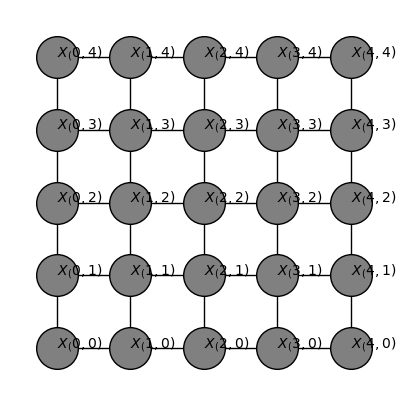

In [134]:
usda_pgm.draw_grid_graph(5,5)  

### 3.5.2.1 二值型随机变量的 MRF 建模——以图像降噪为例<sup>[The Markov Random Field for Image Denoising - JMA, <https://www.kaggle.com/code/ukveteran/the-markov-random-field-for-image-denoising-jma/notebook>]</sup>

In [246]:
img_fn=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\3_5_d_06.png'    
img_original_mono,img_noise=usda_imgprocess.binarize_noise_image(img_fn,resize=(256,256))   
denoised_img=usda_pgm.MRF_binary(img_original_mono,img_noise)

100%|██████████████████████████████████████████████████████████████████████| 256/256 [00:15<00:00, 16.35it/s]


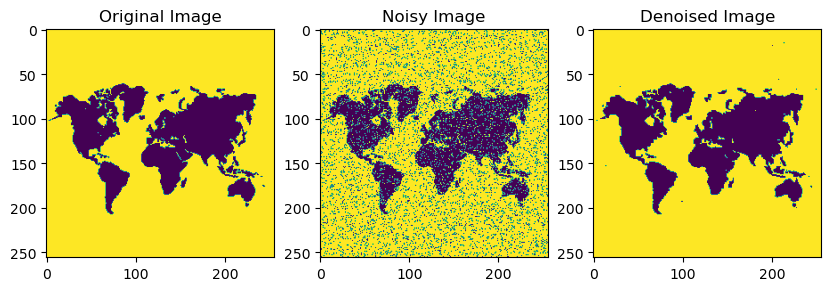

In [252]:
fig, axes=plt.subplots(1, 3,figsize=(10,5))
axes[0].imshow(img_original_mono)
axes[1].imshow(img_noise)
axes[2].imshow(denoised_img)

axes[0].set_title('Original Image')
axes[1].set_title('Noisy Image')
axes[2].set_title('Denoised Image')

plt.show()

### 3.5.2.2 离散型随机变量的 MRF 建模——以图像分割为例<sup>[Markov Random Fields, W.G.H.S. Weligampola (E/14/379),June 2020,<https://www.cs.umd.edu/~gihan/resources/em509/>]</sup>

In [255]:
img_fn=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\3_5_d_01.jpg'
seg=usda_pgm.Image_segmentation_using_MRF(img_fn,nlevels=7,win_dim=64,imshow=False)

64
32
16
8


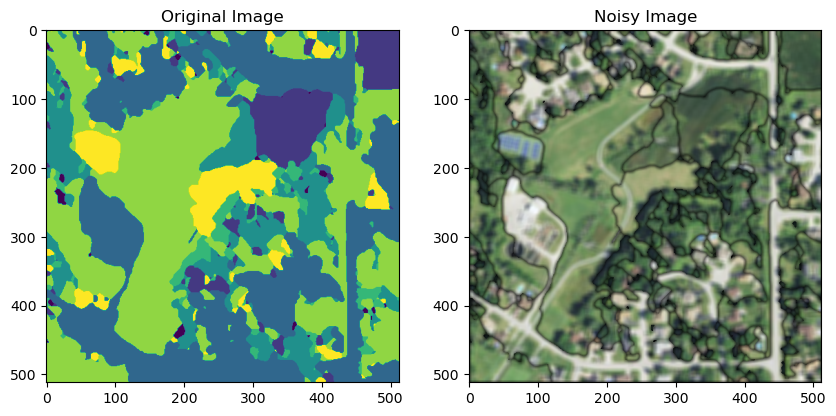

In [257]:
fig, axes=plt.subplots(1, 2,figsize=(10,5))
out=seg.ACAreconstruction(seg.lev,seg.locav)

axes[0].imshow(seg.lev*20)
axes[1].imshow(out/np.max(out))

axes[0].set_title('Original Image')
axes[1].set_title('Noisy Image')

plt.show()

### 3.5.2.3 连续型随机变量的 MRF 建模——以图像降噪为例

In [174]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torch.optim import RMSprop

In [263]:
class MRF_continuous:
    
    def __init__(self,noisy_img,channel=0,original_img=None,cuda=False):
        to_tensor=ToTensor()
        noisy=to_tensor(Image.open(noisy_img))[channel] 
        
        if cuda:
            noisy=noisy.cuda()
        
        
        
noisy_img=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\mri_image_noise_level_high.png'      
original_img=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\mri_image_noiseless.png'
mrf_c=MRF_continuous(noisy_img,original_img=original_img)        

In [176]:
def mrf_prior(x, a=0):
    return x**2

def mrf_loss(X, noisy, a):
    loss1 = ((noisy - X)**2).sum()
    loss2 = 0
    loss2 += mrf_prior(X[:, 1: ] - X[:, :-1]).sum()
    loss2 += mrf_prior(X[:-1, :] - X[ 1:, :]).sum()
    return a*loss1 + 2*loss2

In [178]:
to_tensor = ToTensor()
RRMSE = lambda x: (((gt - x)**2).sum() / (gt**2).sum())**0.5

In [180]:
noisy = to_tensor(Image.open(r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\mri_image_noise_level_high.png'))[0] #.cuda()
gt    = to_tensor(Image.open(r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\mri_image_noiseless.png'))[0] #.cuda()

In [184]:
X = torch.zeros_like(noisy)#.cuda()
X.requires_grad = True
errors = []
losses = []
images = []
alpha  = 6.7

In [187]:
optimizer = RMSprop([X])

In [188]:
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [210]:
n_it   = 100

for it in tqdm(range(n_it)):
    optimizer.zero_grad()
    loss = mrf_loss(X, noisy, alpha)
    loss.backward()
    optimizer.step()
    errors.append(RRMSE(X))
    losses.append(loss.item())
    images.append(np.array(255*X.clone().detach()).astype(np.uint8))

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 358.52it/s]


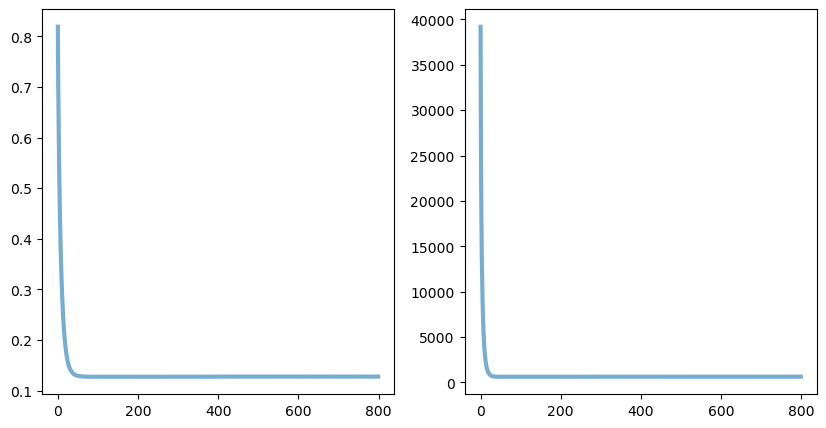

In [211]:
fig, axes=plt.subplots(1, 2,figsize=(10,5))
steps = np.arange(0, n_it+1)

errors_detach=[i.detach().numpy() for i in errors]
axes[0].plot(np.arange(0,len(errors_detach)),errors_detach, lw=3, alpha=0.6)
axes[1].plot(np.arange(0,len(losses)),losses, lw=3, alpha=0.6)

usda_vis.plot_style_axis_A(ax)
plt.show()

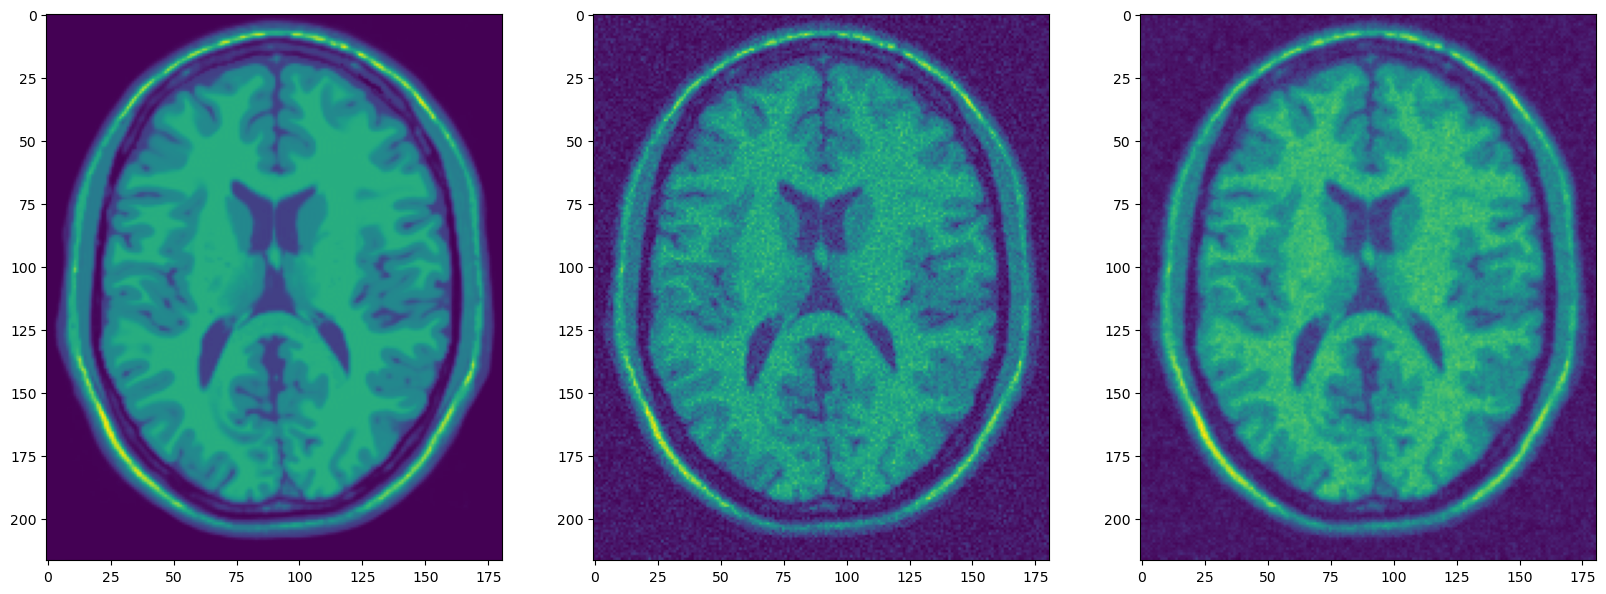

In [213]:
fig, axes=plt.subplots(1, 3,figsize=(20,10))
axes[0].imshow(gt)
axes[1].imshow(noisy)
axes[2].imshow(images[-1])

plt.show()

In [217]:
a=X[:, 1: ]
a.shape

torch.Size([217, 180])

In [215]:
X.shape

torch.Size([217, 181])

In [218]:
b=X[:, :-1]
b.shape

torch.Size([217, 180])